# World Financial Centers Clustering 
### by Neighborhood Nearby Venue Frequency

In [84]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

from foursquare import venue_frequency, rank_venues_by_frequency, hash_venue_categories
from geocoder import enrich_neighborhoods_with_geocoder, map_neighborhoods, map_clusters

from yellowbrick.cluster import KElbowVisualizer

### Load mined datasets

In [85]:
world_coordinates = pd.read_csv('data/world_neighborhood_coords.csv', index_col=0)
world_coordinates

,Neighborhood,City,Latitude,Longitude
0,Yuqiao,Beijing,39.898820,116.670814
1,Shigezhuang,Beijing,39.931943,116.557680
2,Beitaipingzhuang,Beijing,39.973639,116.363844
3,Yongdingmenwai,Beijing,39.866794,116.392355
4,Jinding Avenue,Beijing,39.934977,116.389006
...,...,...,...,...
1262,Langstrasse,Zurich,47.377273,8.526415
1263,Enge,Zurich,47.361789,8.528708
1264,Lindenhof,Zurich,47.372916,8.540176
1265,Leimbach,Zurich,47.390254,8.581406


In [86]:
world_venue_frequency = pd.read_csv('data/world_neighborhood_venues_frequency.csv', index_col=0)
world_venue_frequency

,City,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Neighborhood,,,,,,,
Aberdeen,Hong Kong,0.000000,0.666667,0.000000,0.095238,0.095238,0.142857
Adelaide,Toronto,0.025000,0.650000,0.025000,0.050000,0.100000,0.150000
Admiralty,Hong Kong,0.023810,0.619048,0.071429,0.047619,0.142857,0.095238
Agincourt,Toronto,0.000000,0.916667,0.000000,0.000000,0.000000,0.083333
Agincourt North,Toronto,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...
Zhongguancun,Beijing,0.000000,0.666667,0.000000,0.000000,0.222222,0.111111
Zōshigaya,Tokyo,0.055556,0.555556,0.000000,0.055556,0.166667,0.166667
one-north,Singapore,0.000000,0.888889,0.037037,0.037037,0.037037,0.000000


In [90]:
world_venue_frequency.set_index([world_venue_frequency.index, 'City'], drop=True, inplace=True)
world_venue_frequency

,,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Neighborhood,City,,,,,,
Aberdeen,Hong Kong,0.000000,0.666667,0.000000,0.095238,0.095238,0.142857
Adelaide,Toronto,0.025000,0.650000,0.025000,0.050000,0.100000,0.150000
Admiralty,Hong Kong,0.023810,0.619048,0.071429,0.047619,0.142857,0.095238
Agincourt,Toronto,0.000000,0.916667,0.000000,0.000000,0.000000,0.083333
Agincourt North,Toronto,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...
Zhongguancun,Beijing,0.000000,0.666667,0.000000,0.000000,0.222222,0.111111
Zōshigaya,Tokyo,0.055556,0.555556,0.000000,0.055556,0.166667,0.166667
one-north,Singapore,0.000000,0.888889,0.037037,0.037037,0.037037,0.000000


In [87]:
world_venues = pd.read_csv('data/world_neighborhood_venues.csv', index_col=0)
world_venues

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Category,Address
0,Sanlitun,Beijing,39.936105,116.448813,The Opposite House (瑜舍),Hotel,Travel & Transport,"('Sanlitun', 'Beijing')"
1,Sanlitun,Beijing,39.936105,116.448813,Page One (叶壹堂),Bookstore,Shop & Service,"('Sanlitun', 'Beijing')"
2,Sanlitun,Beijing,39.936105,116.448813,Nali Patio (那里花园),Shopping Mall,Shop & Service,"('Sanlitun', 'Beijing')"
3,Sanlitun,Beijing,39.936105,116.448813,The Black Moth,Cocktail Bar,Nightlife Spot,"('Sanlitun', 'Beijing')"
4,Sanlitun,Beijing,39.936105,116.448813,Bottega,Italian Restaurant,Food,"('Sanlitun', 'Beijing')"
...,...,...,...,...,...,...,...,...
13166,Wipkingen,Zurich,47.393495,8.528602,Bahnhof Zürich Wipkingen,Train Station,Travel & Transport,"('Wipkingen', 'Zurich')"
13167,Wipkingen,Zurich,47.393495,8.528602,Tre Frattelli,Italian Restaurant,Food,"('Wipkingen', 'Zurich')"
13168,Wipkingen,Zurich,47.393495,8.528602,Migros,Grocery Store,Shop & Service,"('Wipkingen', 'Zurich')"
13169,Wipkingen,Zurich,47.393495,8.528602,Damas,Eastern European Restaurant,Food,"('Wipkingen', 'Zurich')"


### Run k-means with k optimized by elbow method

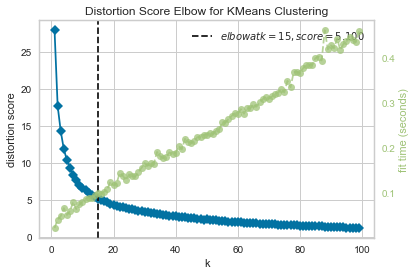

In [91]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,100))

visualizer.fit(world_venue_frequency)
visualizer.show()

In [92]:
k=15

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(world_venue_frequency)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 1,  1,  1,  4, 10,  7,  3,  3,  7,  2], dtype=int32)

In [94]:
silhouette = metrics.silhouette_score(world_venue_frequency, kmeans.labels_)
silhouette

0.22551114803293015

In [95]:
# add clustering labels
world_venue_frequency.insert(0, "Cluster Labels", kmeans.labels_)
world_venue_frequency

,,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport
Neighborhood,City,,,,,,,
Aberdeen,Hong Kong,1,0.000000,0.666667,0.000000,0.095238,0.095238,0.142857
Adelaide,Toronto,1,0.025000,0.650000,0.025000,0.050000,0.100000,0.150000
Admiralty,Hong Kong,1,0.023810,0.619048,0.071429,0.047619,0.142857,0.095238
Agincourt,Toronto,4,0.000000,0.916667,0.000000,0.000000,0.000000,0.083333
Agincourt North,Toronto,10,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000
...,...,...,...,...,...,...,...,...
Zhongguancun,Beijing,9,0.000000,0.666667,0.000000,0.000000,0.222222,0.111111
Zōshigaya,Tokyo,1,0.055556,0.555556,0.000000,0.055556,0.166667,0.166667
one-north,Singapore,4,0.000000,0.888889,0.037037,0.037037,0.037037,0.000000


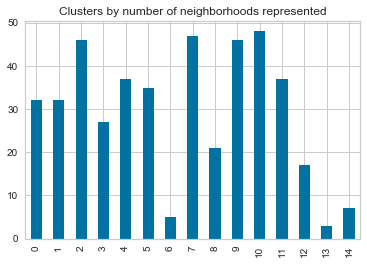

In [96]:
world_venue_frequency['Cluster Labels'].value_counts().sort_index().plot(kind='bar')
plt.title('Clusters by number of neighborhoods represented')
plt.show()

In [97]:
clustered_neighborhoods = pd.merge(left=world_venue_frequency, right=world_coordinates, on=['Neighborhood', 'City'], how="inner")
clustered_neighborhoods.head()

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
0,Aberdeen,Hong Kong,1,0.00000,0.666667,0.000000,0.095238,0.095238,0.142857,22.248769,114.155954
1,Adelaide,Toronto,1,0.02500,0.650000,0.025000,0.050000,0.100000,0.150000,43.650809,-79.377917
2,Admiralty,Hong Kong,1,0.02381,0.619048,0.071429,0.047619,0.142857,0.095238,22.278921,114.164498
3,Agincourt,Toronto,4,0.00000,0.916667,0.000000,0.000000,0.000000,0.083333,43.785353,-79.278549
4,Agincourt North,Toronto,10,0.00000,0.800000,0.000000,0.000000,0.200000,0.000000,43.808038,-79.266439


In [98]:
p = clustered_neighborhoods[['City', 'Cluster Labels']].pivot_table(values='City', index='Cluster Labels', aggfunc=set)
p

,City
Cluster Labels,
0,"{London, Toronto, Hong Kong, Tokyo, Singapore,..."
1,"{Toronto, Hong Kong, Tokyo, Singapore, Shangha..."
2,"{Toronto, Beijing, Hong Kong, Tokyo, Singapore..."
3,"{Toronto, Hong Kong, Tokyo, New York City, Lon..."
4,"{Toronto, Hong Kong, Tokyo, Singapore, New Yor..."
5,"{Toronto, Beijing, Hong Kong, Tokyo, Singapore..."
6,"{New York City, Toronto, London, Beijing}"
7,"{Toronto, Hong Kong, Tokyo, Singapore, Shangha..."
8,"{Toronto, Hong Kong, Tokyo, Singapore, Zurich,..."


In [99]:
p2 = clustered_neighborhoods[['City', 'Cluster Labels']].pivot_table(values='Cluster Labels', index='City', aggfunc=set)
p2

,Cluster Labels
City,
Beijing,"{2, 5, 6, 9, 10, 14}"
Frankfurt,"{0, 1, 7, 10, 12}"
Hong Kong,"{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 14}"
London,"{0, 2, 3, 5, 6, 9, 11, 12, 13}"
New York City,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
Shanghai,"{0, 1, 2, 5, 7, 10, 11}"
Singapore,"{0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 14}"
Tokyo,"{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14}"
Toronto,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}"


In [116]:
clustered_venues = pd.merge(left=world_venues, right=clustered_neighborhoods[['Neighborhood', 'City', 'Cluster Labels']], on=['Neighborhood', 'City'], how="left")
clustered_venues.head()

,Neighborhood,City,Latitude,Longitude,Venue,Venue Category,Category,Address,Cluster Labels
0,Sanlitun,Beijing,39.936105,116.448813,The Opposite House (瑜舍),Hotel,Travel & Transport,"('Sanlitun', 'Beijing')",10
1,Sanlitun,Beijing,39.936105,116.448813,Page One (叶壹堂),Bookstore,Shop & Service,"('Sanlitun', 'Beijing')",10
2,Sanlitun,Beijing,39.936105,116.448813,Nali Patio (那里花园),Shopping Mall,Shop & Service,"('Sanlitun', 'Beijing')",10
3,Sanlitun,Beijing,39.936105,116.448813,The Black Moth,Cocktail Bar,Nightlife Spot,"('Sanlitun', 'Beijing')",10
4,Sanlitun,Beijing,39.936105,116.448813,Bottega,Italian Restaurant,Food,"('Sanlitun', 'Beijing')",10


In [117]:
clustered_venues.to_csv('data/world_neighborhood_venues_clustered.csv')
# clustered_neighborhoods = pd.read_csv('data/world_neighborhood_venues_clustered.csv', index_col=0)
# clustered_neighborhoods

In [ ]:
# See Tableau dashboard for better vizualization of cluster distribution

### Save assigned clusters

In [115]:
clustered_neighborhoods.to_csv('data/world_neighborhoods_clustered.csv')
# clustered_neighborhoods = pd.read_csv('data/world_neighborhood_venues_clustered.csv', index_col=0)
# clustered_neighborhoods

## Visualize geospatial clusters

In [101]:
t = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Toronto'], k, 'Toronto, Ontario')
t

In [102]:
tk = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Tokyo'], k, 'Tokyo, Japan')
tk

In [103]:
z = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Zurich'], k, 'Zurich, Switzerland')
z

In [104]:
b = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Beijing'], k, 'Beijing, China')
b

In [105]:
ny = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'New York City'], k, 'New York City, NY')
ny

In [106]:
shang = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Shanghai'], k, 'Shanghai, China')
shang

In [107]:
sing = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Singapore'], k, 'Singapore, China')
sing

In [108]:
f = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Frankfurt'], k, 'Frankfurt, Germany')
f

In [109]:
l = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'London'], k, 'London, England')
l

In [110]:
hk = map_clusters(clustered_neighborhoods[clustered_neighborhoods['City'] == 'Hong Kong'], k, 'Hong Kong, China')
hk

## Analyze clusters by venue rankings

In [112]:
categories = clustered_neighborhoods.columns[3:-2]
categories

Index(['Arts & Entertainment', 'Food', 'Nightlife Spot',
       'Outdoors & Recreation', 'Shop & Service', 'Travel & Transport'],
      dtype='object')

## Cluster 0 - Above Average Travel, Service, Outdoors

In [111]:
cluster_0 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 0]
cluster_0.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
19,Banchō,Tokyo,0,0.000000,0.545455,0.060606,0.090909,0.181818,0.121212,35.685423,139.732192
36,Boon Lay,Singapore,0,0.000000,0.545455,0.000000,0.000000,0.272727,0.181818,1.345640,103.711802
37,Boon Lay Place,Singapore,0,0.000000,0.545455,0.000000,0.181818,0.272727,0.000000,1.347517,103.713880
48,Běixīnjīng,Shanghai,0,0.000000,0.500000,0.000000,0.000000,0.300000,0.200000,31.218828,121.368126
52,Carnegie Hill,New York City,0,0.060606,0.363636,0.090909,0.151515,0.333333,0.000000,40.782683,-73.953256
54,Carroll Gardens,New York City,0,0.000000,0.520833,0.083333,0.083333,0.291667,0.020833,40.680540,-73.994654
69,City,Zurich,0,0.031250,0.437500,0.156250,0.093750,0.187500,0.093750,47.372943,8.535346
96,Dhoby Ghaut,Singapore,0,0.027778,0.527778,0.000000,0.111111,0.277778,0.055556,1.299353,103.845309
105,East Harlem,New York City,0,0.035714,0.500000,0.035714,0.142857,0.285714,0.000000,40.792249,-73.944182
106,East Tremont,New York City,0,0.000000,0.461538,0.076923,0.076923,0.230769,0.153846,40.842696,-73.887356


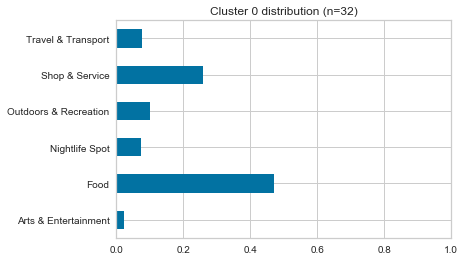

In [141]:
cluster_0[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 0 distribution (n={})'.format(cluster_0.shape[0]))
plt.show()

In [121]:
clustered_venues[clustered_venues['Cluster Labels'] == 0].Venue.value_counts()[0:5]

Starbucks        10
Chase Bank        6
Pret A Manger     4
Dunkin'           4
sweetgreen        3
Name: Venue, dtype: int64

In [122]:
clustered_venues[clustered_venues['Cluster Labels'] == 0]['Venue Category'].value_counts()[0:5]

Coffee Shop           52
Italian Restaurant    30
Hotel                 30
Café                  25
Pizza Place           23
Name: Venue Category, dtype: int64

In [154]:
clustered_venues[clustered_venues['Cluster Labels'] == 0]['Address'].value_counts()[0:5]

('Midtown South', 'New York City')    93
('Midtown', 'New York City')          87
('West Village', 'New York City')     83
('North Side', 'New York City')       74
('Flatiron', 'New York City')         56
Name: Address, dtype: int64

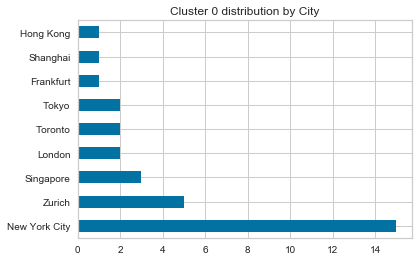

In [135]:
cluster_0['City'].value_counts().plot(kind='barh')

plt.title('Cluster 0 distribution by City')
plt.show()

## Cluster 1 - Above Average Travel and Food

In [136]:
cluster_1 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 1]
cluster_1.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
0,Aberdeen,Hong Kong,1,0.000000,0.666667,0.000000,0.095238,0.095238,0.142857,22.248769,114.155954
1,Adelaide,Toronto,1,0.025000,0.650000,0.025000,0.050000,0.100000,0.150000,43.650809,-79.377917
2,Admiralty,Hong Kong,1,0.023810,0.619048,0.071429,0.047619,0.142857,0.095238,22.278921,114.164498
17,Asakusa,Tokyo,1,0.029412,0.647059,0.088235,0.000000,0.117647,0.117647,35.717528,139.797635
21,Bath Beach,New York City,1,0.000000,0.700000,0.100000,0.000000,0.100000,0.100000,40.599519,-73.998752
38,Bras Basah,Singapore,1,0.166667,0.633333,0.066667,0.000000,0.033333,0.100000,1.296821,103.850666
64,Chinatown,Singapore,1,0.017544,0.631579,0.052632,0.000000,0.175439,0.122807,1.283737,103.843798
82,Commerce Court,Toronto,1,0.033333,0.683333,0.050000,0.033333,0.133333,0.066667,43.648095,-79.379021
89,Cyberport,Hong Kong,1,0.052632,0.631579,0.000000,0.105263,0.105263,0.105263,22.260697,114.130286
129,Gallus,Frankfurt,1,0.000000,0.666667,0.000000,0.083333,0.166667,0.083333,50.103658,8.636706


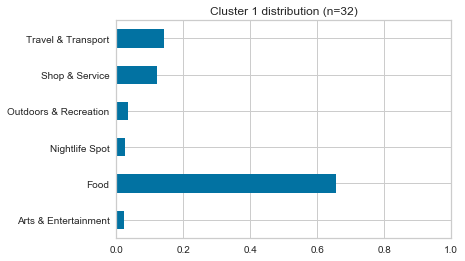

In [139]:
cluster_1[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 1 distribution (n={})'.format(cluster_1.shape[0]))
plt.show()

In [142]:
clustered_venues[clustered_venues['Cluster Labels'] == 1].Venue.value_counts()[0:5]

Starbucks          16
Subway              6
Starbucks (星巴克)     5
Tim Hortons         5
McDonald's          4
Name: Venue, dtype: int64

In [143]:
clustered_venues[clustered_venues['Cluster Labels'] == 1]['Venue Category'].value_counts()[0:5]

Coffee Shop             51
Café                    46
Hotel                   44
Chinese Restaurant      33
Fast Food Restaurant    20
Name: Venue Category, dtype: int64

In [153]:
clustered_venues[clustered_venues['Cluster Labels'] == 1]['Address'].value_counts()[0:5]

('Commerce Court', 'Toronto')    60
('Chinatown', 'Singapore')       57
('Harbourfront', 'Toronto')      44
('Admiralty', 'Hong Kong')       42
('Adelaide', 'Toronto')          40
Name: Address, dtype: int64

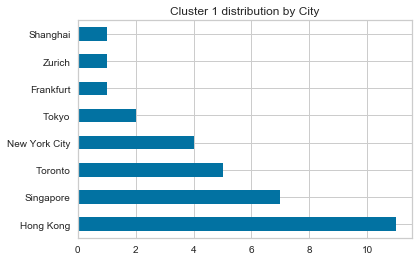

In [145]:
cluster_1['City'].value_counts().plot(kind='barh')

plt.title('Cluster 1 distribution by City')
plt.show()

## Cluster 2 - Above Average Service

In [146]:
cluster_2 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 2]
cluster_2.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
9,Allerton,New York City,2,0.000000,0.500000,0.000000,0.071429,0.428571,0.000000,40.865788,-73.859319
32,Bishan,Singapore,2,0.057143,0.600000,0.000000,0.000000,0.342857,0.000000,1.351452,103.848250
34,Boerum Hill,New York City,2,0.000000,0.526316,0.105263,0.000000,0.368421,0.000000,40.685683,-73.983748
40,Brighton Beach,New York City,2,0.000000,0.500000,0.000000,0.083333,0.416667,0.000000,40.576825,-73.965094
42,Brooklyn Heights,New York City,2,0.020000,0.480000,0.000000,0.100000,0.400000,0.000000,40.695864,-73.993782
90,Cáojiādù,Shanghai,2,0.000000,0.608696,0.000000,0.043478,0.347826,0.000000,31.231680,121.422633
91,"Daikanyamachō, Shibuya",Tokyo,2,0.021739,0.586957,0.043478,0.043478,0.304348,0.000000,35.649763,139.702428
92,Dashilan,Beijing,2,0.000000,0.555556,0.000000,0.055556,0.333333,0.055556,39.894498,116.390172
99,Don Mills North,Toronto,2,0.000000,0.500000,0.000000,0.000000,0.437500,0.062500,43.775347,-79.345944
123,Forest Hill West,Toronto,2,0.083333,0.583333,0.000000,0.000000,0.333333,0.000000,43.701028,-79.425600


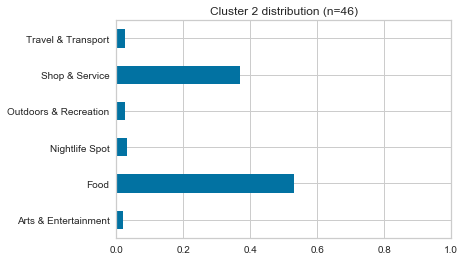

In [147]:
cluster_2[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 2 distribution (n={})'.format(cluster_2.shape[0]))
plt.show()

In [148]:
clustered_venues[clustered_venues['Cluster Labels'] == 2].Venue.value_counts()[0:5]

Starbucks      11
Dunkin'         9
Tim Hortons     7
Subway          7
Chase Bank      7
Name: Venue, dtype: int64

In [149]:
clustered_venues[clustered_venues['Cluster Labels'] == 2]['Venue Category'].value_counts()[0:5]

Coffee Shop           69
Café                  49
Clothing Store        42
Italian Restaurant    41
Boutique              36
Name: Venue Category, dtype: int64

In [152]:
clustered_venues[clustered_venues['Cluster Labels'] == 2]['Address'].value_counts()[0:5]

('Greenwich Village', 'New York City')    100
('Orchard', 'Singapore')                   95
('Harajuku', 'Tokyo')                      92
('Kingston upon Thames', 'London')         67
('Sasazuka', 'Tokyo')                      65
Name: Address, dtype: int64

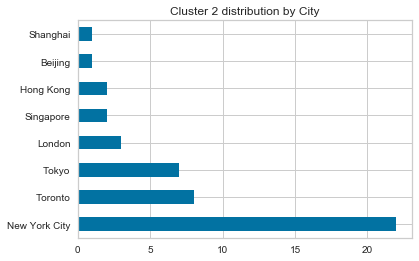

In [151]:
cluster_2['City'].value_counts().plot(kind='barh')

plt.title('Cluster 2 distribution by City')
plt.show()

## Cluster 3 - Excellent Service, Below Average Food

In [155]:
cluster_3 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 3]
cluster_3.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
6,Akihabara,Tokyo,3,0.121212,0.383838,0.040404,0.010101,0.424242,0.020202,35.699736,139.771250
7,Albion Gardens,Toronto,3,0.000000,0.454545,0.000000,0.000000,0.545455,0.000000,43.741665,-79.584543
28,Bayview Village,Toronto,3,0.000000,0.400000,0.000000,0.000000,0.500000,0.100000,43.769197,-79.376662
41,Bromley,London,3,0.024390,0.317073,0.000000,0.073171,0.585366,0.000000,51.402805,0.014814
72,City Line,New York City,3,0.000000,0.357143,0.000000,0.000000,0.642857,0.000000,40.678570,-73.867976
111,Enfield,London,3,0.020833,0.354167,0.041667,0.000000,0.541667,0.041667,51.652085,-0.081017
122,Fordham,New York City,3,0.026316,0.315789,0.000000,0.105263,0.526316,0.026316,40.860997,-73.896427
127,Fresh Meadows,New York City,3,0.000000,0.200000,0.000000,0.000000,0.500000,0.300000,40.734394,-73.782713
174,Jamaica Center,New York City,3,0.000000,0.428571,0.000000,0.035714,0.535714,0.000000,40.704657,-73.796902
230,Metro City Plaza,Hong Kong,3,0.076923,0.384615,0.000000,0.000000,0.538462,0.000000,22.324220,114.256957


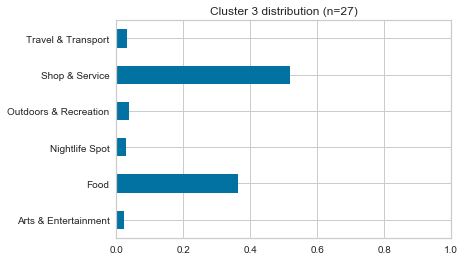

In [156]:
cluster_3[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 3 distribution (n={})'.format(cluster_3.shape[0]))
plt.show()

In [157]:
clustered_venues[clustered_venues['Cluster Labels'] == 3].Venue.value_counts()[0:5]

Subway             7
Starbucks          6
H&M                5
Chase Bank         5
TD Canada Trust    5
Name: Venue, dtype: int64

In [158]:
clustered_venues[clustered_venues['Cluster Labels'] == 3]['Venue Category'].value_counts()[0:5]

Clothing Store    45
Coffee Shop       22
Pharmacy          17
Sandwich Place    17
Pizza Place       17
Name: Venue Category, dtype: int64

In [159]:
clustered_venues[clustered_venues['Cluster Labels'] == 3]['Address'].value_counts()[0:5]

('Akihabara', 'Tokyo')       99
('Soho', 'New York City')    50
('Enfield', 'London')        48
('Trinity', 'Toronto')       45
('Bromley', 'London')        41
Name: Address, dtype: int64

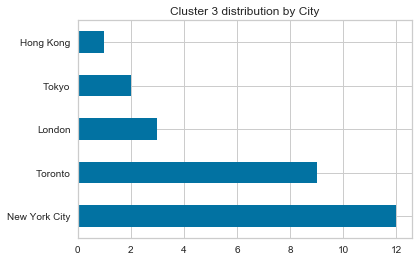

In [160]:
cluster_3['City'].value_counts().plot(kind='barh')

plt.title('Cluster 3 distribution by City')
plt.show()

## Cluster 4 - Best Food

In [161]:
cluster_4 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 4]
cluster_4.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
3,Agincourt,Toronto,4,0.0,0.916667,0.000000,0.0,0.000000,0.083333,43.785353,-79.278549
16,Asagaya,Tokyo,4,0.0,0.892857,0.035714,0.0,0.071429,0.000000,35.703164,139.636247
35,Boon Keng,Singapore,4,0.0,0.937500,0.000000,0.0,0.062500,0.000000,1.319569,103.861749
39,Brickworks,Singapore,4,0.0,1.000000,0.000000,0.0,0.000000,0.000000,1.286933,103.807560
45,Bukit Ho Swee,Singapore,4,0.0,0.964286,0.000000,0.0,0.035714,0.000000,1.287995,103.828564
53,Caroline Hill,Hong Kong,4,0.0,1.000000,0.000000,0.0,0.000000,0.000000,22.276537,114.186479
76,Clementi,Singapore,4,0.0,0.866667,0.000000,0.0,0.133333,0.000000,1.314026,103.762410
86,Crawford,Singapore,4,0.0,0.916667,0.000000,0.0,0.000000,0.083333,1.305586,103.863088
93,Davisville North,Toronto,4,0.0,0.933333,0.000000,0.0,0.066667,0.000000,43.704312,-79.388517
116,Farrer Park,Singapore,4,0.0,0.851852,0.000000,0.0,0.037037,0.111111,1.312591,103.854229


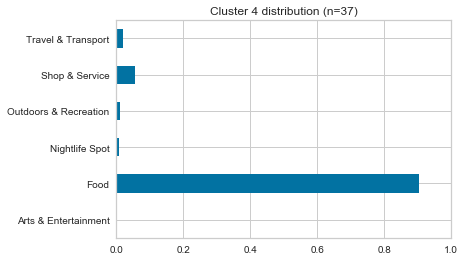

In [162]:
cluster_4[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 4 distribution (n={})'.format(cluster_4.shape[0]))
plt.show()

In [163]:
clustered_venues[clustered_venues['Cluster Labels'] == 4].Venue.value_counts()[0:5]

Subway                 8
Starbucks              8
McDonald's (麥當勞)       6
McDonald's / McCafé    5
Starbucks (星巴克)        5
Name: Venue, dtype: int64

In [164]:
clustered_venues[clustered_venues['Cluster Labels'] == 4]['Venue Category'].value_counts()[0:5]

Chinese Restaurant     71
Coffee Shop            59
Noodle House           42
Café                   36
Japanese Restaurant    36
Name: Venue Category, dtype: int64

In [165]:
clustered_venues[clustered_venues['Cluster Labels'] == 4]['Address'].value_counts()[0:5]

('Sai Ying Pun', 'Hong Kong')           57
('Jurong West Central', 'Singapore')    53
('Kowloon City', 'Hong Kong')           44
('Kennedy Town', 'Hong Kong')           34
('Kwun Chung', 'Hong Kong')             33
Name: Address, dtype: int64

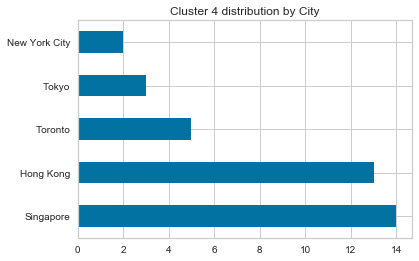

In [166]:
cluster_4['City'].value_counts().plot(kind='barh')

plt.title('Cluster 4 distribution by City')
plt.show()

## Cluster 5 - Best Nightlife

In [167]:
cluster_5 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 5]
cluster_5.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
29,Beixinqiao,Beijing,5,0.071429,0.714286,0.214286,0.000000,0.000000,0.000000,39.939384,116.410870
31,Berczy Park,Toronto,5,0.070175,0.561404,0.157895,0.052632,0.070175,0.087719,43.647984,-79.375396
33,Boat Quay,Singapore,5,0.045455,0.545455,0.181818,0.181818,0.000000,0.045455,1.285939,103.852150
51,Camden,London,5,0.000000,0.545455,0.181818,0.090909,0.090909,0.090909,51.542305,-0.139560
57,Central District,Hong Kong,5,0.000000,0.571429,0.214286,0.035714,0.142857,0.035714,22.281322,114.160258
58,Central Harlem,New York City,5,0.050000,0.600000,0.200000,0.100000,0.050000,0.000000,40.815976,-73.943211
60,Chelsea,New York City,5,0.031250,0.593750,0.187500,0.031250,0.093750,0.062500,40.744035,-74.003116
61,Chelsea,New York City,5,0.031250,0.593750,0.187500,0.031250,0.093750,0.062500,40.594726,-74.189560
75,Clarke Quay,Singapore,5,0.000000,0.512821,0.179487,0.076923,0.128205,0.102564,1.288187,103.846396
77,Clifford Pier,Singapore,5,0.000000,0.722222,0.194444,0.055556,0.000000,0.027778,1.283947,103.853538


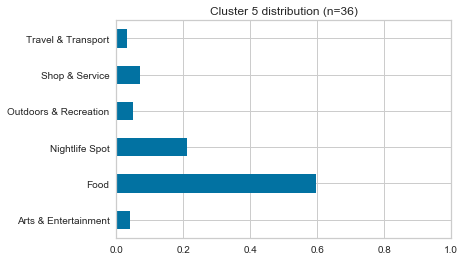

In [168]:
cluster_5[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 5 distribution (n={})'.format(cluster_5.shape[0]))
plt.show()

In [169]:
clustered_venues[clustered_venues['Cluster Labels'] == 5].Venue.value_counts()[0:5]

Starbucks                  12
Tim Hortons                 8
Costa Coffee                4
Wheat Baumkuchen            3
Yakiniku Toraji (焼肉トラジ)     3
Name: Venue, dtype: int64

In [170]:
clustered_venues[clustered_venues['Cluster Labels'] == 5]['Venue Category'].value_counts()[0:5]

Bar                    86
Café                   70
Sake Bar               61
Coffee Shop            60
Japanese Restaurant    47
Name: Venue Category, dtype: int64

In [238]:
clustered_venues[clustered_venues['Cluster Labels'] == 5]['Address'].value_counts()[0:15]

('Kabukichō', 'Tokyo')               99
('East Village', 'New York City')    99
('Ikebukuro', 'Tokyo')               81
('Shiodome', 'Tokyo')                69
('Shinjuku Golden Gai', 'Tokyo')     68
('Chelsea', 'New York City')         64
('Shimokitazawa', 'Tokyo')           62
('Shinjuku Ni-chōme', 'Tokyo')       59
('Rathaus', 'Zurich')                59
('Berczy Park', 'Toronto')           57
('Langstrasse', 'Zurich')            55
('Tateishi', 'Tokyo')                50
('Hibiya', 'Tokyo')                  48
('Kanda', 'Tokyo')                   45
('Kampong Glam', 'Singapore')        45
Name: Address, dtype: int64

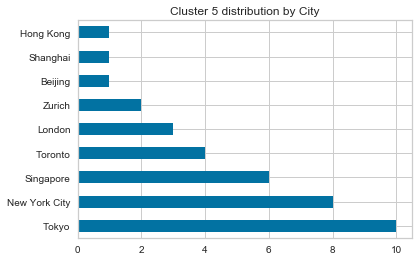

In [172]:
cluster_5['City'].value_counts().plot(kind='barh')

plt.title('Cluster 5 distribution by City')
plt.show()

## Cluster 6 - Best Arts, Excellent Outdoors, Low Service

In [173]:
cluster_6 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 6]
cluster_6.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
49,CN Tower,Toronto,6,0.342857,0.285714,0.171429,0.114286,0.028571,0.057143,43.642564,-79.387087
113,Exhibition Place,Toronto,6,0.428571,0.357143,0.071429,0.071429,0.071429,0.000000,43.633813,-79.417141
140,Greenwich,London,6,0.416667,0.166667,0.083333,0.250000,0.000000,0.083333,51.482084,-0.004542
211,Lincoln Square,New York City,6,0.526316,0.157895,0.000000,0.236842,0.052632,0.026316,40.773529,-73.985338
366,Tianqiao,Beijing,6,0.600000,0.200000,0.000000,0.000000,0.100000,0.100000,39.881214,116.392294


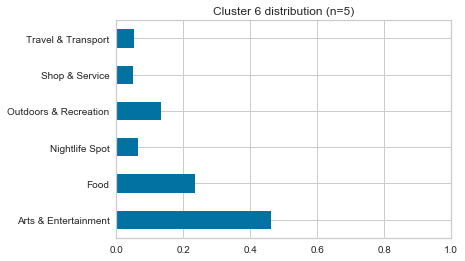

In [174]:
cluster_6[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 6 distribution (n={})'.format(cluster_6.shape[0]))
plt.show()

In [175]:
clustered_venues[clustered_venues['Cluster Labels'] == 6].Venue.value_counts()[0:5]

Starbucks                                    2
Second Cup                                   2
Barclay's Capital Grove at Lincoln Center    1
Met Opera Shop                               1
Lincoln Center Theater                       1
Name: Venue, dtype: int64

In [176]:
clustered_venues[clustered_venues['Cluster Labels'] == 6]['Venue Category'].value_counts()[0:5]

Theater           9
Hotel             5
Café              5
Aquarium          5
History Museum    4
Name: Venue Category, dtype: int64

In [177]:
clustered_venues[clustered_venues['Cluster Labels'] == 6]['Address'].value_counts()[0:5]

('Lincoln Square', 'New York City')    38
('CN Tower', 'Toronto')                35
('Exhibition Place', 'Toronto')        14
('Greenwich ', 'London')               12
('Tianqiao', 'Beijing')                10
Name: Address, dtype: int64

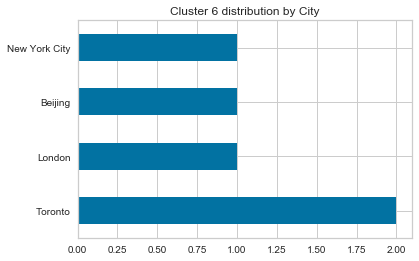

In [178]:
cluster_6['City'].value_counts().plot(kind='barh')

plt.title('Cluster 6 distribution by City')
plt.show()

## Cluster 7 - (largest) Excellent Food, Worst Service

In [179]:
cluster_7 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 7]
cluster_7.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
5,Akasaka,Tokyo,7,0.055556,0.796296,0.018519,0.037037,0.055556,0.037037,35.671679,139.735622
8,Aljunied,Singapore,7,0.000000,0.769231,0.000000,0.076923,0.076923,0.076923,1.316452,103.882909
18,Bahnhofsviertel,Frankfurt,7,0.000000,0.719298,0.105263,0.000000,0.087719,0.087719,50.107741,8.668736
59,Chai Wan,Hong Kong,7,0.000000,0.818182,0.000000,0.090909,0.000000,0.090909,22.264783,114.237238
62,Cheung Chau,Hong Kong,7,0.000000,0.733333,0.066667,0.133333,0.000000,0.066667,22.209614,114.029637
67,Christie,Toronto,7,0.000000,0.741935,0.129032,0.064516,0.064516,0.000000,43.664111,-79.418405
85,Corona,New York City,7,0.000000,0.818182,0.000000,0.090909,0.090909,0.000000,40.742382,-73.856825
94,Deer Park,Toronto,7,0.000000,0.782609,0.065217,0.065217,0.086957,0.000000,43.688090,-79.394094
109,"Ebisu, Shibuya",Tokyo,7,0.000000,0.790000,0.110000,0.020000,0.080000,0.000000,35.646438,139.710210
114,Fairview,Toronto,7,0.000000,0.727273,0.000000,0.181818,0.000000,0.090909,43.653963,-79.387207


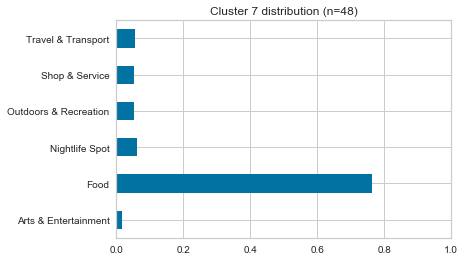

In [180]:
cluster_7[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 7 distribution (n={})'.format(cluster_7.shape[0]))
plt.show()

In [181]:
clustered_venues[clustered_venues['Cluster Labels'] == 7].Venue.value_counts()[0:5]

Starbucks          35
Subway             12
Starbucks (星巴克)    11
Tim Hortons         8
Mos Mos Coffee      4
Name: Venue, dtype: int64

In [182]:
clustered_venues[clustered_venues['Cluster Labels'] == 7]['Venue Category'].value_counts()[0:5]

Coffee Shop            124
Café                    89
Japanese Restaurant     84
Chinese Restaurant      62
Italian Restaurant      54
Name: Venue Category, dtype: int64

In [239]:
clustered_venues[clustered_venues['Cluster Labels'] == 7]['Address'].value_counts()[0:10]

('Roppongi', 'Tokyo')                     100
('Ebisu, Shibuya', 'Tokyo')               100
('Murray Hill', 'New York City')           88
('Toronto Dominion Centre', 'Toronto')     61
('King', 'Toronto')                        58
('Nishiogikubo', 'Tokyo')                  58
('Bahnhofsviertel', 'Frankfurt')           57
('First Canadian Place', 'Toronto')        55
('Akasaka', 'Tokyo')                       54
('Studio District', 'Toronto')             53
Name: Address, dtype: int64

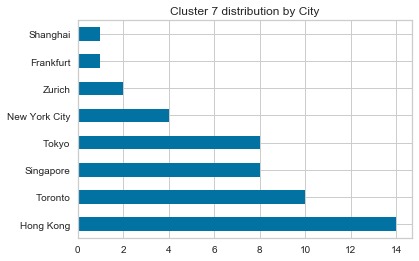

In [184]:
cluster_7['City'].value_counts().plot(kind='barh')

plt.title('Cluster 7 distribution by City')
plt.show()

## Cluster 8 - Excellent Outdoors, Above Average Arts

In [185]:
cluster_8 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 8]
cluster_8.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
22,Bathurst Quay,Toronto,8,0.000000,0.600000,0.000000,0.200000,0.100000,0.100000,43.635791,-79.398329
23,Battery Park City,New York City,8,0.031250,0.406250,0.031250,0.218750,0.281250,0.031250,40.711932,-74.016869
74,Civic Center,New York City,8,0.055556,0.527778,0.027778,0.250000,0.138889,0.000000,40.715229,-74.005415
80,Cobble Hill,New York City,8,0.000000,0.454545,0.090909,0.272727,0.181818,0.000000,40.687920,-73.998561
102,Dumbo,New York City,8,0.062500,0.437500,0.000000,0.250000,0.250000,0.000000,40.703176,-73.988753
121,Flushing,New York City,8,0.142857,0.428571,0.000000,0.214286,0.142857,0.071429,40.764454,-73.831773
124,Fort Greene,New York City,8,0.035714,0.535714,0.071429,0.178571,0.178571,0.000000,40.688527,-73.972906
128,Fulton Ferry,New York City,8,0.076923,0.410256,0.076923,0.256410,0.025641,0.153846,40.703281,-73.995508
219,Ma Liu Shui,Hong Kong,8,0.000000,0.375000,0.062500,0.250000,0.125000,0.187500,22.413569,114.210103
239,Mountbatten,Singapore,8,0.000000,0.545455,0.000000,0.272727,0.181818,0.000000,1.306249,103.882496


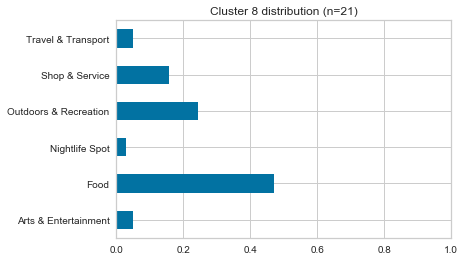

In [186]:
cluster_8[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 8 distribution (n={})'.format(cluster_8.shape[0]))
plt.show()

In [187]:
clustered_venues[clustered_venues['Cluster Labels'] == 8].Venue.value_counts()[0:5]

Starbucks            4
Tim Hortons          2
Schaffhauserplatz    2
sweetgreen           2
7-Eleven             2
Name: Venue, dtype: int64

In [188]:
clustered_venues[clustered_venues['Cluster Labels'] == 8]['Venue Category'].value_counts()[0:5]

Park             20
Coffee Shop      20
Gym              13
Deli / Bodega    10
Playground       10
Name: Venue Category, dtype: int64

In [189]:
clustered_venues[clustered_venues['Cluster Labels'] == 8]['Address'].value_counts()[0:5]

('Dumbo', 'New York City')                48
('Fulton Ferry', 'New York City')         39
('Civic Center', 'New York City')         36
('Battery Park City', 'New York City')    32
('Fort Greene', 'New York City')          28
Name: Address, dtype: int64

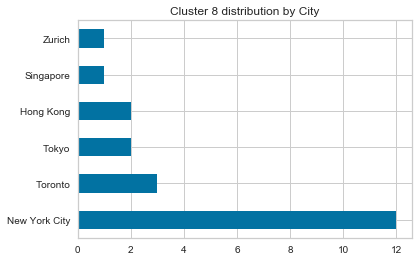

In [190]:
cluster_8['City'].value_counts().plot(kind='barh')

plt.title('Cluster 8 distribution by City')
plt.show()

## Cluster 9 - (large) Above Average Food and Service

In [191]:
cluster_9 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 9]
cluster_9.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
11,Altstetten,Zurich,9,0.000000,0.588235,0.000000,0.058824,0.294118,0.058824,47.387403,8.486061
14,"Aoyama, Minato",Tokyo,9,0.043478,0.652174,0.000000,0.043478,0.260870,0.000000,35.671073,139.720839
27,Bayside,New York City,9,0.000000,0.714286,0.000000,0.000000,0.285714,0.000000,40.766041,-73.774274
43,Bugis,Singapore,9,0.000000,0.625000,0.025000,0.025000,0.275000,0.050000,1.299953,103.855278
44,Bukit Batok,Singapore,9,0.050000,0.700000,0.000000,0.000000,0.250000,0.000000,1.349057,103.749591
46,Bukit Merah,Singapore,9,0.000000,0.600000,0.000000,0.100000,0.300000,0.000000,1.280628,103.830591
55,Causeway Bay,Hong Kong,9,0.000000,0.681818,0.022727,0.022727,0.250000,0.022727,22.280208,114.184841
66,Chong Boon,Singapore,9,0.000000,0.666667,0.000000,0.000000,0.250000,0.083333,1.368207,103.856360
68,Church and Wellesley,Toronto,9,0.062500,0.656250,0.031250,0.062500,0.187500,0.000000,43.665524,-79.383801
81,College Point,New York City,9,0.000000,0.687500,0.000000,0.000000,0.250000,0.062500,40.784903,-73.843045


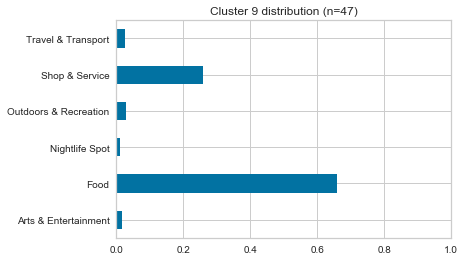

In [192]:
cluster_9[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 9 distribution (n={})'.format(cluster_9.shape[0]))
plt.show()

In [193]:
clustered_venues[clustered_venues['Cluster Labels'] == 9].Venue.value_counts()[0:5]

Starbucks                     18
Subway                        11
McDonald's                     8
Dunkin'                        7
The Coffee Bean & Tea Leaf     6
Name: Venue, dtype: int64

In [194]:
clustered_venues[clustered_venues['Cluster Labels'] == 9]['Venue Category'].value_counts()[0:5]

Chinese Restaurant      64
Coffee Shop             55
Café                    42
Japanese Restaurant     41
Fast Food Restaurant    37
Name: Venue Category, dtype: int64

In [195]:
clustered_venues[clustered_venues['Cluster Labels'] == 9]['Address'].value_counts()[0:5]

('Otome Road', 'Tokyo')         71
('Jurong East', 'Singapore')    58
('Ealing', 'London')            53
('Odaiba', 'Tokyo')             48
('Toyosu', 'Tokyo')             48
Name: Address, dtype: int64

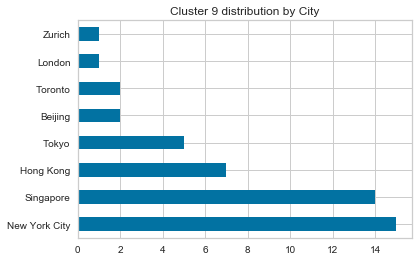

In [196]:
cluster_9['City'].value_counts().plot(kind='barh')

plt.title('Cluster 9 distribution by City')
plt.show()

## Cluster 10 - (largest) Excellent Food 

In [197]:
cluster_10 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 10]
cluster_10.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
4,Agincourt North,Toronto,10,0.000000,0.800000,0.000000,0.000000,0.200000,0.000000,43.808038,-79.266439
12,Amoy Gardens,Hong Kong,10,0.000000,0.789474,0.000000,0.000000,0.157895,0.052632,22.324627,114.216458
13,Ang Mo Kio,Singapore,10,0.041667,0.708333,0.000000,0.041667,0.208333,0.000000,1.370073,103.849516
47,Bushwick,New York City,10,0.000000,0.700000,0.150000,0.000000,0.150000,0.000000,40.698116,-73.925258
56,Central Bay Street,Toronto,10,0.000000,0.700000,0.033333,0.100000,0.166667,0.000000,43.660912,-79.385897
65,Chinatown,Toronto,10,0.000000,0.769231,0.051282,0.000000,0.179487,0.000000,43.652924,-79.398032
73,City One Shatin,Hong Kong,10,0.000000,0.760000,0.000000,0.000000,0.200000,0.040000,22.386618,114.203512
95,Design Exchange,Toronto,10,0.048387,0.709677,0.032258,0.048387,0.112903,0.048387,43.647741,-79.380115
98,Discovery Bay,Hong Kong,10,0.000000,0.727273,0.045455,0.090909,0.136364,0.000000,22.297369,114.016528
100,Downtown,New York City,10,0.035714,0.696429,0.035714,0.017857,0.196429,0.017857,40.690844,-73.983463


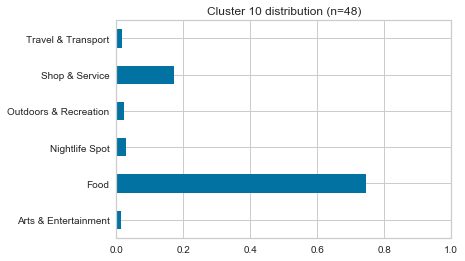

In [198]:
cluster_10[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 10 distribution (n={})'.format(cluster_10.shape[0]))
plt.show()

In [199]:
clustered_venues[clustered_venues['Cluster Labels'] == 10].Venue.value_counts()[0:5]

Starbucks           25
Subway              10
Starbucks (星巴克)      9
McDonald's (麥當勞)     8
Tim Hortons          8
Name: Venue, dtype: int64

In [200]:
clustered_venues[clustered_venues['Cluster Labels'] == 10]['Venue Category'].value_counts()[0:5]

Coffee Shop            77
Café                   66
Chinese Restaurant     66
Japanese Restaurant    43
Bakery                 37
Name: Venue Category, dtype: int64

In [201]:
clustered_venues[clustered_venues['Cluster Labels'] == 10]['Address'].value_counts()[0:5]

('Kichijōji', 'Tokyo')                100
('Design Exchange', 'Toronto')         62
('Sanlitun', 'Beijing')                58
('Hunters Point', 'New York City')     56
('Downtown', 'New York City')          56
Name: Address, dtype: int64

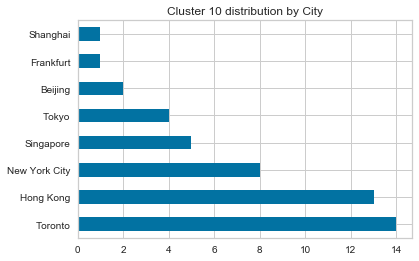

In [202]:
cluster_10['City'].value_counts().plot(kind='barh')

plt.title('Cluster 10 distribution by City')
plt.show()

## Cluster 11 - Above Average Nightlife and Arts

In [203]:
cluster_11 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 11]
cluster_11.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
24,Bay Ridge,New York City,11,0.050000,0.600000,0.100000,0.000000,0.250000,0.000000,40.625801,-74.030621
30,Belmont,New York City,11,0.047619,0.619048,0.047619,0.047619,0.238095,0.000000,40.857277,-73.888452
50,Cabbagetown,Toronto,11,0.037037,0.592593,0.074074,0.000000,0.296296,0.000000,43.664473,-79.366986
63,Chinatown,New York City,11,0.037736,0.641509,0.075472,0.037736,0.169811,0.037736,40.715618,-73.994279
70,City Hall,Singapore,11,0.048780,0.609756,0.073171,0.000000,0.219512,0.048780,1.292861,103.852689
71,City Island,New York City,11,0.142857,0.571429,0.071429,0.000000,0.214286,0.000000,40.847247,-73.786488
79,Clinton Hill,New York City,11,0.000000,0.636364,0.090909,0.030303,0.212121,0.030303,40.693229,-73.967843
97,Diamond Hill,Hong Kong,11,0.133333,0.600000,0.000000,0.000000,0.200000,0.066667,22.340031,114.201609
143,Hammersmith and Fulham,London,11,0.037736,0.584906,0.094340,0.056604,0.150943,0.075472,51.492038,-0.223640
151,"Higashi, Shibuya",Tokyo,11,0.062500,0.583333,0.083333,0.000000,0.270833,0.000000,35.706475,139.682847


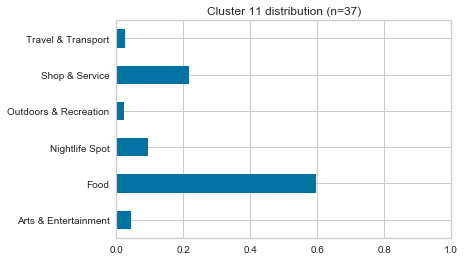

In [204]:
cluster_11[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 11 distribution (n={})'.format(cluster_11.shape[0]))
plt.show()

In [205]:
clustered_venues[clustered_venues['Cluster Labels'] == 11].Venue.value_counts()[0:5]

Starbucks                  14
Seijo Ishii (成城石井)          7
Tully's Coffee              4
Yayoi (やよい軒)                4
Mister Donut (ミスタードーナツ)     3
Name: Venue, dtype: int64

In [206]:
clustered_venues[clustered_venues['Cluster Labels'] == 11]['Venue Category'].value_counts()[0:5]

Coffee Shop            72
Japanese Restaurant    68
Café                   67
Convenience Store      61
Sake Bar               48
Name: Venue Category, dtype: int64

In [207]:
clustered_venues[clustered_venues['Cluster Labels'] == 11]['Address'].value_counts()[0:5]

('Little Italy', 'New York City')    100
('Marunouchi', 'Tokyo')               83
('Yoyogi', 'Tokyo')                   81
('Omotesandō', 'Tokyo')               81
('Ōmori, Ōta', 'Tokyo')               74
Name: Address, dtype: int64

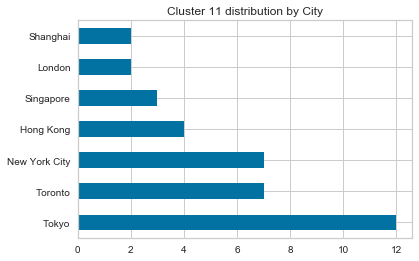

In [208]:
cluster_11['City'].value_counts().plot(kind='barh')

plt.title('Cluster 11 distribution by City')
plt.show()

## Cluster 12 - Excellent Arts and Nightlife

In [209]:
cluster_12 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 12]
cluster_12.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
10,Altstadt,Frankfurt,12,0.145833,0.520833,0.104167,0.104167,0.125000,0.000000,50.111045,8.682936
15,Areas of Tokyo,Tokyo,12,0.192308,0.384615,0.000000,0.076923,0.230769,0.115385,35.734279,139.712855
20,Bankenviertel,Frankfurt,12,0.285714,0.428571,0.142857,0.071429,0.000000,0.071429,50.110589,8.672952
78,Clinton,New York City,12,0.208333,0.333333,0.166667,0.145833,0.104167,0.041667,40.759101,-73.996119
88,Croydon,London,12,0.086957,0.391304,0.260870,0.000000,0.260870,0.000000,51.371305,-0.101957
108,East Williamsburg,New York City,12,0.166667,0.466667,0.266667,0.000000,0.100000,0.000000,40.708492,-73.938858
136,Grange Park,Toronto,12,0.222222,0.444444,0.000000,0.055556,0.277778,0.000000,43.652197,-79.392319
147,Hatsudai,Tokyo,12,0.180328,0.491803,0.098361,0.016393,0.213115,0.000000,35.681640,139.687124
156,"Honmachi, Shibuya",Tokyo,12,0.196429,0.517857,0.089286,0.035714,0.160714,0.000000,35.681589,139.685102
160,Hudson Yards,New York City,12,0.130435,0.347826,0.130435,0.173913,0.173913,0.043478,40.756658,-74.000111


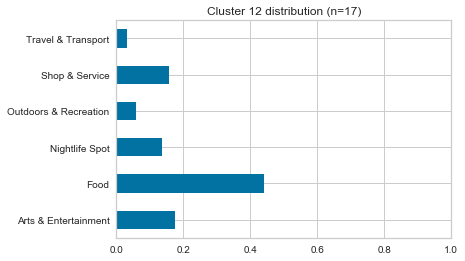

In [210]:
cluster_12[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 12 distribution (n={})'.format(cluster_12.shape[0]))
plt.show()

In [211]:
clustered_venues[clustered_venues['Cluster Labels'] == 12].Venue.value_counts()[0:5]

Starbucks             3
Seijo Ishii (成城石井)    3
Subway                3
EXCELSIOR CAFFÉ       2
Le Pain Quotidien     2
Name: Venue, dtype: int64

In [212]:
clustered_venues[clustered_venues['Cluster Labels'] == 12]['Venue Category'].value_counts()[0:5]

Coffee Shop          33
Café                 29
Bar                  14
Pub                  14
Convenience Store    14
Name: Venue Category, dtype: int64

In [213]:
clustered_venues[clustered_venues['Cluster Labels'] == 12]['Address'].value_counts()[0:5]

('Hatsudai', 'Tokyo')             61
('Honmachi, Shibuya', 'Tokyo')    56
('Altstadt', 'Frankfurt')         48
('Clinton', 'New York City')      48
('Mainhattan', 'Frankfurt')       47
Name: Address, dtype: int64

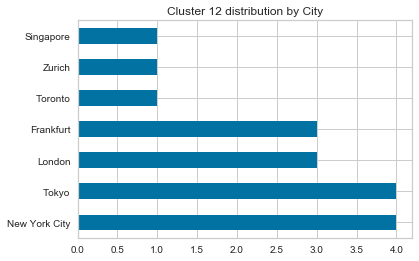

In [214]:
cluster_12['City'].value_counts().plot(kind='barh')

plt.title('Cluster 12 distribution by City')
plt.show()

## Cluster 13 - (smallest) Best Outdoors, Excellent Travel, Worst Food

In [215]:
cluster_13 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 13]
cluster_13.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
25,Bay Terrace,New York City,13,0.0,0.272727,0.0,0.272727,0.181818,0.272727,40.782843,-73.776802
26,Bay Terrace,New York City,13,0.0,0.272727,0.0,0.272727,0.181818,0.272727,40.553988,-74.139166
167,Imado,Tokyo,13,0.0,0.000000,0.0,0.363636,0.454545,0.181818,35.719345,139.803548
374,Tower Hamlets,London,13,0.0,0.200000,0.1,0.300000,0.300000,0.100000,51.495957,-0.011744


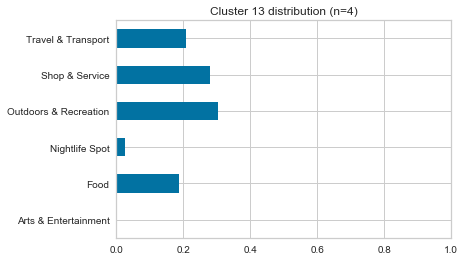

In [216]:
cluster_13[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 13 distribution (n={})'.format(cluster_13.shape[0]))
plt.show()

In [228]:
clustered_venues[clustered_venues['Cluster Labels'] == 13].Venue.value_counts()[0:5]

Bay Terrace Tennis Center    2
PS 53 Park                   2
MTA Q13 Bus Terminal         2
Outback Steakhouse           2
Bay Terrace Playground       2
Name: Venue, dtype: int64

In [218]:
clustered_venues[clustered_venues['Cluster Labels'] == 13]['Venue Category'].value_counts()[0:5]

Playground           4
Bus Station          4
Bus Stop             4
Park                 4
Convenience Store    4
Name: Venue Category, dtype: int64

In [219]:
clustered_venues[clustered_venues['Cluster Labels'] == 13]['Address'].value_counts()[0:5]

('Bay Terrace', 'New York City')    22
('Imado', 'Tokyo')                  11
('Tower Hamlets', 'London')         10
Name: Address, dtype: int64

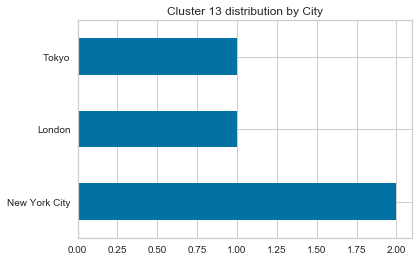

In [220]:
cluster_13['City'].value_counts().plot(kind='barh')

plt.title('Cluster 13 distribution by City')
plt.show()

## Cluster 14 - Best Travel

In [221]:
cluster_14 = clustered_neighborhoods[clustered_neighborhoods['Cluster Labels'] == 14]
cluster_14.head(10)

,Neighborhood,City,Cluster Labels,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,Travel & Transport,Latitude,Longitude
84,Concourse,New York City,14,0.076923,0.461538,0.000000,0.000000,0.230769,0.230769,40.834284,-73.915589
199,Kranji,Singapore,14,0.083333,0.333333,0.000000,0.166667,0.000000,0.416667,1.425219,103.761989
271,Ping Shek Estate,Hong Kong,14,0.090909,0.545455,0.000000,0.090909,0.000000,0.272727,22.332874,114.209101
320,Shin-Kiba,Tokyo,14,0.000000,0.354839,0.032258,0.000000,0.193548,0.419355,35.646183,139.828043
335,Southern Islands,Singapore,14,0.071429,0.428571,0.071429,0.000000,0.000000,0.428571,1.271089,103.863280
368,Tin Shui Wai,Hong Kong,14,0.000000,0.400000,0.100000,0.000000,0.200000,0.300000,22.459611,114.002238
422,Xiaoguan,Beijing,14,0.000000,0.473684,0.157895,0.052632,0.000000,0.315789,39.914162,116.410545


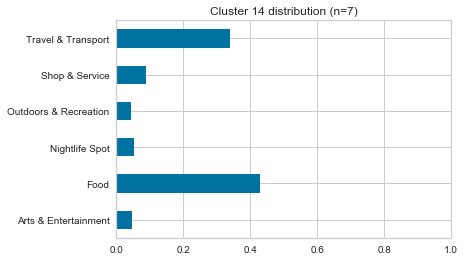

In [222]:
cluster_14[categories].mean().plot(kind='barh')

axes = plt.gca()
axes.set_xlim([0,1])

plt.title('Cluster 14 distribution (n={})'.format(cluster_14.shape[0]))
plt.show()

In [223]:
clustered_venues[clustered_venues['Cluster Labels'] == 14].Venue.value_counts()[0:5]

Starbucks (星巴克)                          2
Lee Garden Service Apartments Beijing    1
Marina South Pier                        1
Naokyu (らーめん直久)                          1
Ngau Chi Wan Civic Centre (牛池灣文娛中心)      1
Name: Venue, dtype: int64

In [224]:
clustered_venues[clustered_venues['Cluster Labels'] == 14]['Venue Category'].value_counts()[0:5]

Hotel                7
Bus Stop             5
Convenience Store    5
Bus Station          5
Boat or Ferry        4
Name: Venue Category, dtype: int64

In [225]:
clustered_venues[clustered_venues['Cluster Labels'] == 14]['Address'].value_counts()[0:5]

('Shin-Kiba', 'Tokyo')               31
('Xiaoguan', 'Beijing')              19
('Southern Islands', 'Singapore')    14
('Concourse', 'New York City')       13
('Kranji', 'Singapore')              12
Name: Address, dtype: int64

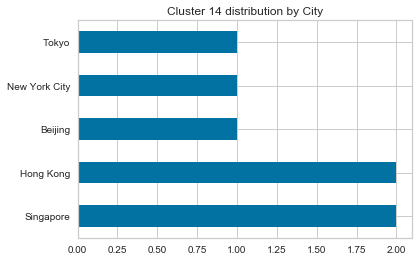

In [226]:
cluster_14['City'].value_counts().plot(kind='barh')

plt.title('Cluster 14 distribution by City')
plt.show()